In [25]:
#Test our best mamba model and transformer solver on 10k test set
import torch
from model import seq2seq_generate_tour,MambaFull, compute_tour_length,generate_data
from benchmarks.transformer_model import TSP_net
from tqdm import tqdm
#from benchmarks.benchmark_solvers import greedy_tsp

coord_dim = 2
city_count = 100
test_size=10000
device = 'cuda'

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


checkpoints = [torch.load('mamba/checkpoints/big/share_50_big_fix_2.pt'),
               torch.load('mamba/checkpoints/big/BIG_city100_2.pt')]


for i, checkpoint_m in enumerate(checkpoints):
    if i==0:
        continue
    args = checkpoint_m['args']
    model = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
    model.load_state_dict(checkpoint_m['model_baseline_state_dict'])
    model.eval()
    
    inputs = generate_data(device, 10, city_count, coord_dim=2 , start = 2)


    Loss_mamba = []
    with torch.no_grad():
        for j in tqdm(range(500)):
            tours ,Logprobofactions = seq2seq_generate_tour(device,model,inputs,deterministic=True,lastlayer=args.last_layer,sum_logactions=False)
            Loss_mamba.append(compute_tour_length(inputs,tours))
            # Shuffle the first dimension (dim1) of the input tensor
            num_cities = inputs.size(1) - 1
            random_permutation = torch.randperm(num_cities)
            perm = torch.cat([random_permutation, torch.tensor([inputs.size(1) - 1])])
            inputs = inputs[:, perm, :]
Loss_mamba = torch.stack(Loss_mamba)
print(Loss_mamba.shape)

100%|██████████| 500/500 [05:58<00:00,  1.39it/s]

torch.Size([500, 10])


100


100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


torch.Size([10])
Problem Name: f0c90f402e0842019718a442bfbbb48e
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1817
   0 Steps   Best: 1490   0.00 seconds
   3 Steps   Best: 1472   0.00 seconds
   7 Steps   Best: 1471   0.00 seconds
   9 Steps   Best: 1463   0.00 seconds
  11 Steps   Best: 1462   0.00 seconds
  12 Steps   Best: 1460   0.00 seconds
  16 Steps   Best: 1458   0.01 seconds
  22 Steps   Best: 1456   0.01 seconds
  24 Steps   Best: 1455   0.01 seconds
  50 Total Steps.
Best cycle length: 1455
Lin-Kernighan Running Time: 0.01
LK Initial Run: 1455.0
LK Run 0: 1455.0
LK Run from best tour: 1455.0
Time to find compression tour: 0.06 (seconds)
Set initial upperbound to 1455 (from tour)
Fractional Matching: 1394.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time 

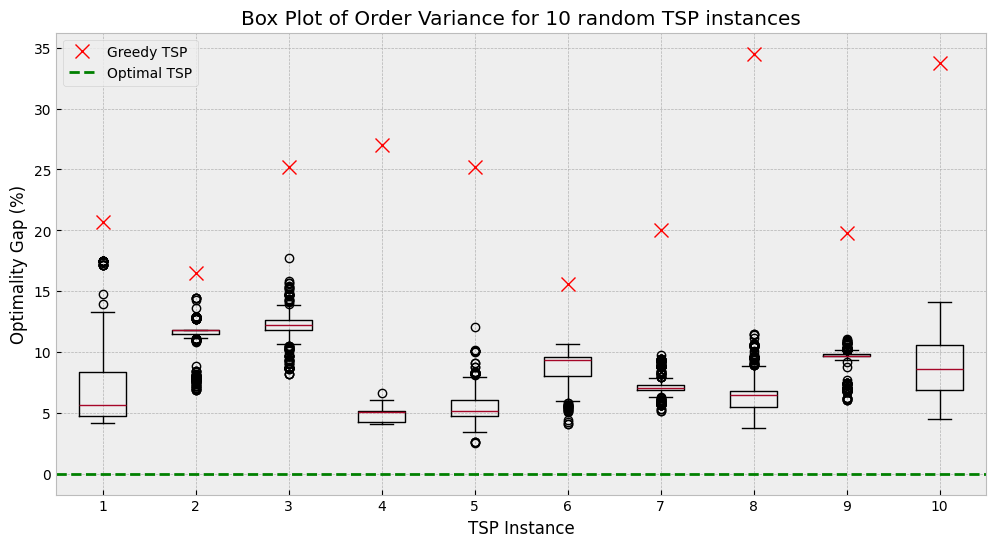

In [26]:
import torch
import matplotlib.pyplot as plt
from benchmarks.benchmark_solvers import greedy_tsp
import pandas as pd
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
from model import compute_tour_length

plt.style.use('bmh')
device = 'cuda'

def create_concorde_tour(test_data):
    x_coord_i = test_data.cpu().numpy()
    graph = pd.DataFrame({'lat': x_coord_i[:,0], 'lon': x_coord_i[:,1]})
    solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
    solution = solver.solve()
    return torch.tensor(solution.tour)

# Assuming Loss_mamba is a 2D tensor on the GPU
Loss_mamba_greedy = torch.zeros(10, device=device)
Loss_mamba_greedy = greedy_tsp(inputs, return_mean=False)[0]
print(Loss_mamba_greedy.shape)

Optimal_tour = torch.stack([create_concorde_tour(inputs[i, :-1, :]) for i in range(10)]).to(device)
Optimal = compute_tour_length(inputs, Optimal_tour, remove_start_token=False)

# Calculate optimality gap
Optimality_gap_mamba = (Loss_mamba.cuda() / Optimal.cuda() - 1) * 100
Optimality_gap_greedy = (Loss_mamba_greedy.cuda() / Optimal.cuda() - 1) * 100

# Transfer the tensors to the CPU
Optimality_gap_mamba_cpu = Optimality_gap_mamba.cpu()
Optimality_gap_greedy_cpu = Optimality_gap_greedy.cpu()

fig, ax = plt.subplots(figsize=(12, 6))

# Create the box plot
bp = ax.boxplot(Optimality_gap_mamba_cpu.permute(1, 0), vert=True)

# Add greedy results as red crosses
x = range(1, 11)  # x-coordinates for the 10 iterations
ax.plot(x, Optimality_gap_greedy_cpu, 'rx', markersize=10, label='Greedy TSP')

# Add a horizontal line at y=0 to represent the optimal solution
ax.axhline(y=0, color='g', linestyle='--', label='Optimal TSP')

ax.set_xlabel('TSP Instance')
ax.set_ylabel('Optimality Gap (%)')
ax.set_title('Box Plot of Order Variance for 10 random TSP instances')
ax.legend()
plt.savefig('mamba/evals/figs/boxplot100.pdf')
plt.show()